### Package Imports

In [25]:
# Explainability
#---------------------------------------------------------------------------------------------------------------
#Explainability Modules
#---------------------------------------------------------------------------------------------------------------
import shap
import lime.lime_tabular
import lime
from gam.gam.gam import GAM 

#---------------------------------------------------------------------------------------------------------------
#Plotting Helpers
#---------------------------------------------------------------------------------------------------------------
from matplotlib import rcParams
from pylab import rcParams
import os
from IPython.display import display_html, display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt


#---------------------------------------------------------------------------------------------------------------
#Load pd and np along with custom modules
#---------------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from utils.perturbation import Perturb, load_models_lendingclub
from utils.helpful_util import display_sklearn_feature_importance, \
                               plot_confusion_matrix, TrainingPlot, get_best_score, neg_pos_logit_coefficients
from utils.ShapExp import display_abs_shapvalues, display_shapvalues, ExplainShap, get_shap_values
import pickle
import keras
import sklearn

#---------------------------------------------------------------------------------------------------------------
#Jupyter Notebook settings
#---------------------------------------------------------------------------------------------------------------
%matplotlib inline
!jupyter nbextension enable --py widgetsnbextension
display(HTML("<style>.container { width:75% !important; }</style>"))
rcParams.update({'figure.autolayout': True})
#import warnings
#warnings.filterwarnings('ignore')
#---------------------------------------------------------------------------------------------------------------
#Helper Plotly Widgets 
#---------------------------------------------------------------------------------------------------------------
models_widg = widgets.ToggleButtons(
    options=[
        'Multilayer Perceptron', 'logistic regression',
        'gradient boosted trees', 'random forest', 'sklearn neural network'
    ],
    description='Models:',
    disabled=False,
    button_style='',
    tooltips=[
                'Multilayer Perceptron', 'sklearn logit',
                'sklearn gradient boosted classifier', 'sklearn random forest', 'sklearn neural network'
    ])

button_widg = widgets.Checkbox(
    value=False,
    description='Check me to save image',
    disabled=False
)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


#### Encode Dataset (Cat Feats)

In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
# ---------------------------------------------------------------------------------------------------------------
# Load Data + Impute NAs
# ---------------------------------------------------------------------------------------------------------------
np.random.seed(1)
df = pd.read_csv('data/loan.csv', index_col=False)
df['emp_length'].fillna(value='unknown', inplace=True)

# ---------------------------------------------------------------------------------------------------------------
# Store Original Column/Feature Maps
# ---------------------------------------------------------------------------------------------------------------
feature_names = df.columns
continuous_features = df.iloc[:, :-
                              1].select_dtypes(include=[np.float64, np.int64]).columns
categorical_features = df.select_dtypes(include=[np.object]).columns
categorical_features_index = [df.columns.get_loc(
    c) for c in categorical_features if c in df]


# ---------------------------------------------------------------------------------------------------------------
# Get Encoded Data + Labels
# ---------------------------------------------------------------------------------------------------------------

# ----------------
# Transform Response
# ----------------
data = np.array(df)
y = data[:, -1]  # response var
le = sklearn.preprocessing.LabelEncoder()  # instantiate label encoder
le.fit(y)  # fit label encoder to response
y = le.transform(y)  # encode response
class_names = le.classes_  # get class names of response


# -------------------
# Transform ind. Vars
# -------------------
data = data[:, :-1]  # Get all Independent Vars

categorical_names = {}
for feature in categorical_features_index:
    le = sklearn.preprocessing.LabelEncoder()  # instantiate label encoder
    le.fit(data[:, feature])  # fit label encoder to categorical features
    # transform categorical features
    data[:, feature] = le.transform(data[:, feature])
    # get categorical feature class names and append to dict
    categorical_names[feature] = le.classes_


# -------------------
# all features as a list. Unwrapping encoding
# -------------------
cat_features_unrolled = []
for k in categorical_names.values():
    for i in k:
        cat_features_unrolled.append(i)

# -------------------
# Make Features dicepherable
# -------------------
cat_features_unrolled[:2] = ['Term:' + i for i in cat_features_unrolled[:2]]
cat_features_unrolled[2:9] = ['Loan_Grade:' +
                              i for i in cat_features_unrolled[2:9]]
cat_features_unrolled[9:44] = ['Loan_SubGrade:' +
                               i for i in cat_features_unrolled[9:44]]
cat_features_unrolled[44:56] = ['Employment_Length:' +
                                i for i in cat_features_unrolled[44:56]]
cat_features_unrolled[56:60] = ['Home_Ownership:' +
                                i for i in cat_features_unrolled[56:60]]
cat_features_unrolled[60:] = ['Loan_Title:' +
                              i for i in cat_features_unrolled[60:]]

# -------------------
# Concatenate encoded features + continuous features
# -------------------
unrolled_features = cat_features_unrolled + list(continuous_features)

# -------------------
# Encode + traintest split
# -------------------
X = data.astype(float)
encoder = sklearn.preprocessing.OneHotEncoder(
    categorical_features=categorical_features_index)  # instantiate OHE
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, train_size=0.80, stratify=y)  # split data

encoder.fit(data)  # OHE Categorical Columns
encoded_train = encoder.transform(X_train)  # Encode Training Set
encoded_test = encoder.transform(X_test)
y_train_keras = y_train


C:\Users\jdine\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.

C:\Users\jdine\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_encoders.py:450: DeprecationWarning:

The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.



#### Model Construction

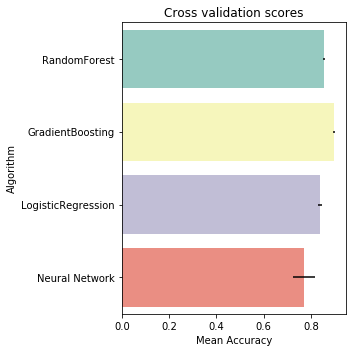

In [3]:
rcParams['figure.figsize'] = 5, 5  # Adjust plot size
#---------------------------------------------------------------------------------------------------------------
# Kfold Cross Val
#---------------------------------------------------------------------------------------------------------------
kfold = StratifiedKFold(n_splits=3)

#-------------------
# Run Kfold CrossVal on base classifiers
#-------------------
random_state = 1
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))


cv_results = []
for classifier in classifiers:
    cv_results.append(
        cross_val_score(classifier,
                        encoded_train,
                        y=y_train,
                        scoring="accuracy",
                        cv=kfold,
                        n_jobs=6))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

#-------------------
# Plot CV Stats
#-------------------
cv_res = pd.DataFrame({
    "CrossValMeans":
    cv_means,
    "CrossValerrors":
    cv_std,
    "Algorithm": ["RandomForest", "GradientBoosting", "LogisticRegression", "Neural Network"]
})

g = sns.barplot("CrossValMeans",
                "Algorithm",
                data=cv_res,
                palette="Set3",
                orient="h",
                **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


In [4]:
#---------------------------------------------------------------------------------------------------------------
# Grid Search parameter space. Cut back on this due to experimentation and compute time
#---------------------------------------------------------------------------------------------------------------

#-------------------
# RFC Parameters tuning
#-------------------
RFC = RandomForestClassifier()
rf_param_grid = {
    "n_estimators": [150, 250]
}
gsRFC = GridSearchCV(RFC,
                     param_grid=rf_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsRFC.fit(encoded_train, y_train)

#-------------------
# Gradient boosting tuning
#-------------------
GBC = GradientBoostingClassifier()
gb_param_grid = {
    'n_estimators': [1000, 2000]
}

gsGBC = GridSearchCV(GBC,
                     param_grid=gb_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsGBC.fit(encoded_train, y_train)

#-------------------
# Sklearn Logit Regression Tuning
#-------------------
LR = LogisticRegression()
LR_param_grid = {'penalty': ['l1', 'l2']}

gsLR = GridSearchCV(LR,
                    param_grid=LR_param_grid,
                    cv=kfold,
                    scoring="accuracy",
                    n_jobs=6,
                    verbose=1)
gsLR.fit(encoded_train, y_train)

#-------------------
# Sklearn ANN Regression Tuning
#-------------------
ANN = MLPClassifier()

# Search grid for optimal parameters
ann_param_grid = {
    "hidden_layer_sizes": [(150),(100,100),(150,150)],
    "activation": ['relu'],
    "solver": ['adam'],
    "learning_rate": ['adaptive'],

}

gsAnn = GridSearchCV(ANN,
                     param_grid=ann_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsAnn.fit(encoded_train, y_train)

#---------------------------------------------------------------------------------------------------------------
# Print Best Scores
#---------------------------------------------------------------------------------------------------------------

print("\033[1mPrinting Best Cross Validation Accuracy.... \033[0m")
print("RF Best Score: {0:.2f} %".format(gsRFC.best_score_ * 100))
print("GBC Best Score: {0:.2f} %".format(gsGBC.best_score_ * 100))
print("Logit Best Score: {0:.2f} %".format(gsLR.best_score_ * 100))
print("MLP Best Score: {0:.2f} %".format(gsAnn.best_score_ * 100))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    9.0s remaining:   18.2s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   14.5s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:   33.3s remaining:  1.1min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.0min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.1s remaining:    2.2s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   20.2s finished
C:\Users\jdine\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\jdine\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:   14.3s finished
C:\Users\jdine\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Printing Best Cross Validation Accuracy.... 
RF Best Score: 89.24 %
GBC Best Score: 93.69 %
Logit Best Score: 88.27 %
MLP Best Score: 74.12 %


In [29]:
#---------------------------------------------------------------------------------------------------------------
# Save Best Estimators
#---------------------------------------------------------------------------------------------------------------

#-------------------
# Model Paths
#-------------------
print("Serializing Best Models\n")
rf_file = "models/LendingClub/random_forest.pkl"
gbc_file = "models/LendingClub/GBC.pkl"
logit_file = "models/LendingClub/Logit.pkl"
ann_file = "models/LendingClub/SklearnNeuralNet.pkl"
path_to_ann = 'models/LendingClub/ann_deepexplain.h5'


pickle.dump(gsRFC.best_estimator_, open(rf_file, 'wb'))
pickle.dump(gsGBC.best_estimator_, open(gbc_file, 'wb'))
pickle.dump(gsLR.best_estimator_, open(logit_file, 'wb'))
pickle.dump(gsAnn.best_estimator_, open(ann_file, 'wb'))

Serializing Best Models



NameError: name 'gsRFC' is not defined

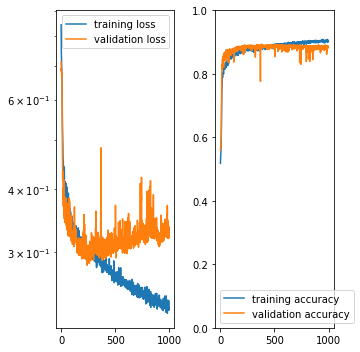

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 4000)              356000    
_________________________________________________________________
batch_normalization_5 (Batch (None, 4000)              16000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 4000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               2000500   
_________________________________________________________________
batch_normalization_6 (Batch (None, 500)               2000      
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               250500    
__________

In [7]:
from utils.helpful_util import TrainingPlot
import tensorflow as tf
import keras
from tensorflow.python.client import device_lib
from keras.losses import binary_crossentropy
from keras.models import Model, load_model, model_from_json, Sequential
from keras.layers import Dense, Input
from keras.utils import layer_utils
from keras import backend as K
from keras.engine.topology import get_source_inputs

from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD, adam, adamax, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU, ELU
from keras.losses import binary_crossentropy
from keras.utils import multi_gpu_model
from sklearn.neural_network import MLPClassifier

#---------------------------------------------------------------------------------------------------------------
#Construct Deep(er) Neural Net. Sklearn was Perceptron (single layer)
#---------------------------------------------------------------------------------------------------------------

MCP = keras.callbacks.ModelCheckpoint(
   "models/LendingClub/ann_deepexplain.h5",
    monitor='val_acc',
    mode='max',
    verbose=1,
    save_best_only=True)

model = Sequential()
model.add(Dense(2000, input_shape = (88,), activation = 'relu'))
model.add(BatchNormalization(momentum = .70))
model.add(Dropout(0.6))
model.add(Dense(500, activation = 'relu'))
model.add(BatchNormalization(momentum = .70))
model.add(Dropout(0.5))
model.add(Dense(500, activation = 'relu'))
model.add(BatchNormalization(momentum = .70))
model.add(Dropout(0.5))
model.add(Dense(250, activation = 'relu'))
model.add(BatchNormalization(momentum = .70))
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

#-------------------
# May Need to Get rid of reference point tf toward gpu. If running on cpu, replace with with tf.device('/cpu:0'):
#-------------------
with tf.device('/gpu:0'):
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                        log_device_placement=True))

    history = model.fit(encoded_train.toarray(), tf.keras.utils.to_categorical(y_train,2), batch_size= 512,
                   epochs=150, verbose=2,\
                        validation_split= .2, callbacks= [MCP, TrainingPlot()])
    sess.close()

model.summary()

#### Load Stored Models From Disk

In [30]:
#---------------------------------------------------------------------------------------------------------------
# Load Models
#---------------------------------------------------------------------------------------------------------------
rfc, gbc, logit, keras_ann, sk_ann = load_models_lendingclub()

# Mapping from Text -> Models for interactive graphs
model_dict_2 = {
    'Multilayer Perceptron': keras_ann,
    'logistic regression': logit,
    'random forest': rfc,
    'gradient boosted trees': gbc,
    'sklearn neural network': sk_ann
}

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


#### Inspecting Model

In [6]:
# ---------------------------------------------------------------------------------------------------------------
# Some classification Reports and Confusion Matrices
# ---------------------------------------------------------------------------------------------------------------
class_names = ['Bad Loan', 'Good Loan']


print("\033[1mTest Accuracy \033[0m")
print("---------------")

def get_best_score(x, y):
    try:
        return sklearn.metrics.accuracy_score(x, y.predict(encoded_test))
    except:
        return sklearn.metrics.accuracy_score(x, y.predict_classes(encoded_test.toarray()))


for keys, values in model_dict_2.items():
    print(keys + ':', end=' ')
    print("{0:.2f} %".format(get_best_score(y_test, values) * 100))


@interact
def classif_reports(model=widgets.ToggleButtons(
        options=[i for i in model_dict_2.keys()])):
    print("\n\033[1m {} Classification Report...\n \033[0m".format(model))
    if model_dict_2[model] == keras_ann:
        cm = confusion_matrix(
            y_test, np.argmax(model_dict_2[model].predict(encoded_test.toarray()), axis=1))
        print(classification_report(y_test, np.argmax(
            model_dict_2[model].predict(encoded_test.toarray()), axis=1)))
    else:
        cm = confusion_matrix(
            y_test, model_dict_2[model].predict(encoded_test))
        print(classification_report(
            y_test, model_dict_2[model].predict(encoded_test)))
    plot_confusion_matrix(cm, classes=class_names, normalize=True)


Test Accuracy 
---------------
Multilayer Perceptron: 88.62 %
logistic regression: 88.40 %
random forest: 90.00 %
gradient boosted trees: 94.12 %
sklearn neural network: 81.83 %


interactive(children=(ToggleButtons(description='model', options=('Multilayer Perceptron', 'logistic regressio…

#### Sklearn Feature Importance


In [136]:
#---------------------------------------------------------------------------------------------------------------
# SciKit Learn Feature Importance in Linear Coefficient Rankinks
#---------------------------------------------------------------------------------------------------------------
rcParams['figure.figsize'] = 5, 5  # Adjust plot size
'''
Logistic Regression Feature importance values are shown as the maximum potential coefficient values based on the max value of
the feature in question * the weight. I have the raw coeff. printed in tables side by side in a block below.
'''

@interact
def sklearn_feature_importance_int(feature_count=widgets.Dropdown(options=list(
        range(1, encoded_train.shape[1])), value=10)):
    display_sklearn_feature_importance(data=encoded_train,
                                       set='lending',
                                       features=unrolled_features,
                                       n_features=feature_count)


interactive(children=(Dropdown(description='feature_count', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1…

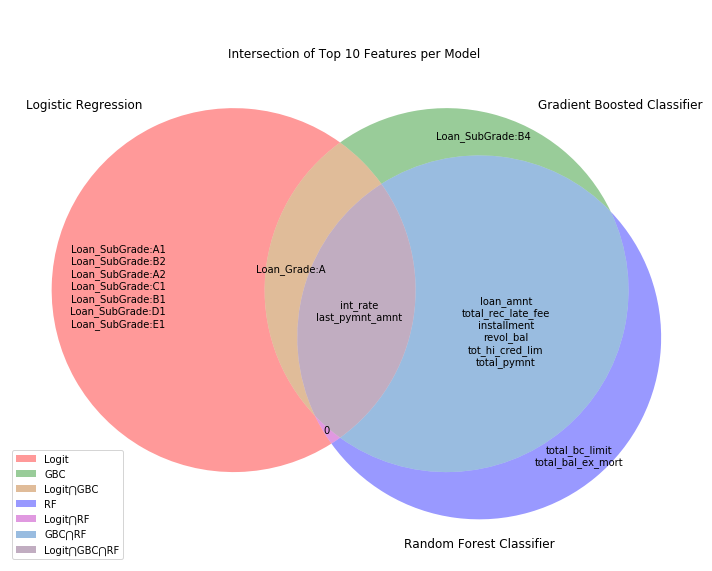

In [348]:
feature_importance = pd.DataFrame({
        "feature":
        unrolled_features,
        "RF_Feature_Importance":
        np.round(rfc.feature_importances_, 4),
        "GBC_Feature_Importance":
        np.round(gbc.feature_importances_, 4),
        "Logit_Coeff":
        np.round(logit.coef_[0], 4),
        "Max_Feature_Val":
        pd.DataFrame(encoded_train.toarray(), columns=unrolled_features).max(),
    })

n = 5
feature_importance['coeff_max'] = feature_importance[
        'Logit_Coeff'] * feature_importance['Max_Feature_Val']

logit_top= set(feature_importance.nlargest(10, 'coeff_max')['feature'])

gbc_top = set(feature_importance.nlargest(10, 'GBC_Feature_Importance')['feature'])

rfc_top = set(feature_importance.nlargest(10, 'RF_Feature_Importance')['feature'])
rcParams['figure.figsize'] = 10,10  # Adjust plot size

#!pip install matplotlib-venn
from matplotlib_venn import venn3
v = venn3([logit_top, gbc_top, rfc_top], ('Logistic Regression', 'Gradient Boosted Classifier', 'Random Forest Classifier'))

v.get_label_by_id('100').set_text('\n'.join(logit_top-gbc_top-rfc_top)) #Just Logit
v.get_label_by_id('110').set_text('\n'.join(logit_top&gbc_top-rfc_top)) #Intersection of Logit and 
v.get_label_by_id('111').set_text('\n'.join(logit_top&gbc_top&rfc_top))
v.get_label_by_id('010').set_text('\n'.join(gbc_top-logit_top-rfc_top))
v.get_label_by_id('011').set_text('\n'.join(rfc_top&gbc_top-logit_top))
v.get_label_by_id('001').set_text('\n'.join(rfc_top-gbc_top-logit_top))

plt.annotate(',\n'.join(B-A-C), xy=v.get_label_by_id('010').get_position() +
             np.array([0, 0.2]), xytext=(-20,40), ha='center',
             textcoords='offset points', 
             bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->',              
                             connectionstyle='arc',color='gray'))
plt.title('Intersection of Top 10 Features per Model ')
plt.legend(['Logit','GBC', 'Logit⋂GBC', 'RF', 'Logit⋂RF', 'GBC⋂RF', 'Logit⋂GBC⋂RF'],loc = 'lower left')
plt.savefig('venn_diagram_Fig1_Replacement.png', eps = 1000, bbox_inches = "tight")
plt.show()


In [173]:
#---------------------------------------------------------------------------------------------------------------
#Side by Side view of Logit Coefficients ( pos & neg) Top 15 in both tables show (by magnitude)
#---------------------------------------------------------------------------------------------------------------
neg_pos_logit_coefficients(model= logit, features = unrolled_features)


,features,Coef
8,Loan_Grade:G,-108.09
7,Loan_Grade:F,-106.94
6,Loan_Grade:E,-69.69
5,Loan_Grade:D,-39.35
0,Term: 36 months,-28.63
1,Term: 60 months,-28.44
28,Loan_SubGrade:D5,-19.58
33,Loan_SubGrade:E5,-16.42
4,Loan_Grade:C,-14.36
23,Loan_SubGrade:C5,-13.57


#### Exploring with Manual Feature Perturbation

###### Categorical Testing

In [120]:
# ---------------------------------------------------------------------------------------------------------------
# Generate a sample of the test set for feature perturbance
# ---------------------------------------------------------------------------------------------------------------

X_test_holdout = X_test.copy()
idx = np.random.choice(X_test_holdout.shape[0], 2000,
                       replace=False)  # Random 2000 samples w/o replacements
X_test_holdout = X_test_holdout[idx]  # extract
X_test_holdout = pd.DataFrame(
    encoder.transform(X_test_holdout).toarray(),
    columns=unrolled_features)  # Convert to DF for column names\
y_test_holdout = y_test[idx]

# ---------------------------------------------------------------------------------------------------------------
# Instantiate Perturb Object
# ---------------------------------------------------------------------------------------------------------------
p = Perturb(X=X_test_holdout, y=y_test_holdout,
            data_str='lending')  # Instantiation. Leave alone


In [ ]:
#Testing Differences between perturbing loan grade + Loan subgrade against original hypothesis

In [14]:
#Testing changing loan subgrade as well
import collections
# ---------------------------------------------------------------------------------------------------------------
# Categorical Pert.
# ---------------------------------------------------------------------------------------------------------------
'''
What this is:
    We take a column, say LoanGrade:A, and systematically turn on null responses at an increasing proportionality.
    E.g., if there are 2000 samples in our holdout test, and LoanGrade:A has 500 '1's':
        Sample From 1500's zeroes.
        Turn on 500 * i zeroes, where i is a step of 0.1
        score
        repeat across 10 random samples
        average predictions across all batches
        step to next i
'''
print('Perturbing Loan Grade A')
p.categorical_perturb_loangrade(column='Loan_Grade:A', grouping='Loan_Grade')



Perturbing Loan Grade A


,0.0,0.2,0.4,0.6,0.8,1.0
Random Forest,1039.0,1046.8,1055.1,1062.6,1071.2,1077.9
Gradient Boosted Classifier,1008.0,1009.0,1009.6,1010.0,1010.9,1012.0
Logistic Regression,1132.0,1166.7,1204.3,1241.5,1269.5,1296.9
Sklearn Neural Network,973.0,976.2,980.1,984.5,989.9,992.3
Multilayer Perceptron,1116.0,1116.0,1116.0,1116.0,1116.0,1116.0


In [22]:
print('Perturbing Loan Grade A + SubloanGrades to A1')
p.categorical_perturb_loangrade_overloaded(column='Loan_Grade:A', grouping='Loan_Grade', sub_column = 'Loan_SubGrade:A1' , subgrouping = 'Loan_SubGrade')


Perturbing Loan Grade A + SubloanGrades to A1


,0.0,0.2,0.4,0.6,0.8,1.0
Random Forest,1039.0,1054.5,1070.1,1084.0,1098.4,1112.7
Gradient Boosted Classifier,1008.0,1010.4,1011.2,1015.7,1014.9,1019.5
Logistic Regression,1132.0,1166.6,1206.5,1237.0,1273.2,1301.2
Sklearn Neural Network,973.0,982.4,989.8,998.8,1001.3,1007.6
Multilayer Perceptron,1116.0,1116.0,1115.9,1116.0,1116.0,1115.9


In [23]:
print('Perturbing Loan Grade A + SubloanGrades to A5')
p.categorical_perturb_loangrade_overloaded(column='Loan_Grade:A', grouping='Loan_Grade', sub_column = 'Loan_SubGrade:A5' , subgrouping = 'Loan_SubGrade')


Perturbing Loan Grade A + SubloanGrades to A5


,0.0,0.2,0.4,0.6,0.8,1.0
Random Forest,1039.0,1050.2,1060.9,1074.3,1084.2,1094.2
Gradient Boosted Classifier,1008.0,1009.1,1009.1,1011.0,1011.3,1012.6
Logistic Regression,1132.0,1168.6,1202.5,1239.5,1267.7,1295.8
Sklearn Neural Network,973.0,981.1,989.9,994.4,1001.3,1006.7
Multilayer Perceptron,1116.0,1116.0,1115.8,1116.0,1115.7,1115.7


In [24]:
print('Perturbing Loan Grade A + SubloanGrades (Even Distribution)')

p.categorical_perturb_loangrade_overloaded_v2(column='Loan_Grade:A', grouping='Loan_Grade',  subgrouping = 'Loan_SubGrade:')


Perturbing Loan Grade A + SubloanGrades (Even Distribution)


,0.0,0.2,0.4,0.6,0.8,1.0
Random Forest,1039.0,1050.0,1063.0,1074.0,1086.0,1100.0
Gradient Boosted Classifier,1008.0,1010.0,1017.0,1015.0,1016.0,1022.0
Logistic Regression,1132.0,1169.0,1209.0,1243.0,1271.0,1314.0
Sklearn Neural Network,973.0,981.0,982.0,993.0,1007.0,1010.0
Multilayer Perceptron,1116.0,1116.0,1116.0,1116.0,1115.0,1115.0


In [32]:
# ---------------------------------------------------------------------------------------------------------------
# Categorical Pert.  Loan Grade D
# ---------------------------------------------------------------------------------------------------------------
p.categorical_perturb_loangrade(column='Loan_Grade:D', grouping='Loan_Grade')

Perturbing column: Loan_Grade:D


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
Random Forest,0.5215,0.5210,0.5165,0.5180,0.5170,0.5150,0.5135,0.5145,0.5115,0.5050,0.5045
Gradient Boosted Classifier,0.5125,0.5125,0.5125,0.5120,0.5115,0.5115,0.5115,0.5125,0.5120,0.5125,0.5100
Logistic Regression,0.5725,0.5620,0.5480,0.5365,0.5285,0.5155,0.5015,0.4885,0.4800,0.4740,0.4550
Sklearn Neural Network,0.4995,0.4990,0.4990,0.4985,0.4975,0.4985,0.4965,0.4955,0.4985,0.4975,0.4955
Multilayer Perceptron,0.5555,0.5555,0.5555,0.5555,0.5550,0.5555,0.5555,0.5555,0.5550,0.5550,0.5555


In [36]:
# ---------------------------------------------------------------------------------------------------------------
# Categorical Pert. Loan_Title:Credit card refinancing
# ---------------------------------------------------------------------------------------------------------------
p.categorical_perturb_loangrade(column='Loan_Title:Credit card refinancing', grouping='Loan_Title')


Perturbing column: Loan_Title:Credit card refinancing


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
Random Forest,0.5215,0.5215,0.5215,0.5220,0.5235,0.5210,0.5230,0.5205,0.5230,0.5220,0.5255
Gradient Boosted Classifier,0.5125,0.5125,0.5130,0.5125,0.5125,0.5125,0.5125,0.5125,0.5130,0.5125,0.5135
Logistic Regression,0.5725,0.5725,0.5735,0.5730,0.5725,0.5735,0.5730,0.5735,0.5745,0.5745,0.5745
Sklearn Neural Network,0.4995,0.5000,0.5010,0.5015,0.5020,0.5010,0.5010,0.5035,0.5035,0.5030,0.5020
Multilayer Perceptron,0.5555,0.5555,0.5555,0.5555,0.5555,0.5555,0.5555,0.5555,0.5555,0.5555,0.5555


###### Continuous Testing

In [135]:
#Metric Testing
iteration = [(i / 100) for i in range(50, 151) if i %10 == 0]




empty_test_metric = {}
for j in continuous_features:
    print("Perturbing column {}".format(j))
    test_metric = {}
    empty_list = [] 
    for step in iteration:
        x_copy = X_test_holdout.copy()
        x_copy[j] = x_copy[j] * step
        empty_list.append((step, collections.Counter(logit.predict(x_copy))[1]))
    empty_test_metric[j] = empty_list

empty_test_metric

Perturbing column loan_amnt
Perturbing column int_rate
Perturbing column installment
Perturbing column annual_inc
Perturbing column inq_last_6mths
Perturbing column revol_bal
Perturbing column total_pymnt
Perturbing column total_rec_late_fee
Perturbing column last_pymnt_amnt
Perturbing column acc_open_past_24mths
Perturbing column delinq_amnt
Perturbing column tax_liens
Perturbing column tot_hi_cred_lim
Perturbing column total_bal_ex_mort
Perturbing column total_bc_limit
Perturbing column total_il_high_credit_limit


{'loan_amnt': [(0.5, 1093),
  (0.6, 1102),
  (0.7, 1109),
  (0.8, 1116),
  (0.9, 1123),
  (1.0, 1132),
  (1.1, 1139),
  (1.2, 1145),
  (1.3, 1150),
  (1.4, 1156),
  (1.5, 1162)],
 'int_rate': [(0.5, 0),
  (0.6, 0),
  (0.7, 0),
  (0.8, 0),
  (0.9, 2),
  (1.0, 1132),
  (1.1, 1876),
  (1.2, 1982),
  (1.3, 1992),
  (1.4, 1994),
  (1.5, 1995)],
 'installment': [(0.5, 1128),
  (0.6, 1129),
  (0.7, 1129),
  (0.8, 1130),
  (0.9, 1131),
  (1.0, 1132),
  (1.1, 1132),
  (1.2, 1135),
  (1.3, 1138),
  (1.4, 1138),
  (1.5, 1139)],
 'annual_inc': [(0.5, 1128),
  (0.6, 1129),
  (0.7, 1129),
  (0.8, 1130),
  (0.9, 1131),
  (1.0, 1132),
  (1.1, 1132),
  (1.2, 1136),
  (1.3, 1138),
  (1.4, 1138),
  (1.5, 1139)],
 'inq_last_6mths': [(0.5, 1134),
  (0.6, 1133),
  (0.7, 1132),
  (0.8, 1132),
  (0.9, 1132),
  (1.0, 1132),
  (1.1, 1132),
  (1.2, 1132),
  (1.3, 1132),
  (1.4, 1132),
  (1.5, 1132)],
 'revol_bal': [(0.5, 1126),
  (0.6, 1128),
  (0.7, 1130),
  (0.8, 1130),
  (0.9, 1130),
  (1.0, 1132),
  (1.1, 11

In [121]:
# ---------------------------------------------------------------------------------------------------------------
# Continuous Pert. Logs
# ---------------------------------------------------------------------------------------------------------------


@interact
def manual_perturb_int(feature=list(X_test_holdout[continuous_features].columns),
                       multiplier=1.0):
    p.manual_perturb(column=feature, scalar=multiplier)


interactive(children=(Dropdown(description='feature', options=('loan_amnt', 'int_rate', 'installment', 'annual…

In [122]:
# Showing Samples
'''
perturbation graphs. 
Two modes: Accuracy & proportion.
    'accuracy' shows the percentage of correct predictions on the holdout set as we iterate through a range of perturbations,
    with a perturbation of 1 = no perturbation at all (scalar multiple of 1 of specified colmns).
    'proportion' shows the percentage of observations classified as being of class 1 as we iterate through perturbations.
    
'''

# ---------------------------------------------------------------------------------------------------------------
# Continuous Pert: Shows Single Model
# ---------------------------------------------------------------------------------------------------------------
from utils.perturbation import load_obj
@interact
def perturb_graph_int(
        models=widgets.ToggleButtons(
            options=[rfc, logit, gbc, keras_ann, sk_ann]),
        mode=widgets.RadioButtons(options=['accuracy', 'proportion']),
        feature=list(X_test_holdout[continuous_features].columns), save=button_widg):
    p.perturb_graph_int(model=models, mode=mode, column=feature)
    if save:
        path = 'images/perturbation_graphs/{}_{}.png'.format(mode, feature)
        plt.savefig(path)
        print("Image saved to {}".format(path))



interactive(children=(ToggleButtons(description='models', options=(RandomForestClassifier(bootstrap=True, clas…

In [123]:
# ---------------------------------------------------------------------------------------------------------------
# Continuous Pert: Shows All Models
# ---------------------------------------------------------------------------------------------------------------
'''
perturbation graphs continued.
This shows the same view as above, except displays all models simulataneously.
'''
@interact
def perturb_graph_cons_int(
        mode=widgets.RadioButtons(options=['accuracy', 'proportion']),
        feature=list(X_test_holdout[continuous_features].columns), save=button_widg):
    p.perturb_graph_cons_int(mode=mode, column=feature)
    if save:
        path = 'images/perturbation_graphs/all_models_{}_{}.png'.format(
            mode, feature)
        plt.savefig(path)
        print("Image saved to {}".format(path))


interactive(children=(RadioButtons(description='mode', options=('accuracy', 'proportion'), value='accuracy'), …

In [124]:
# ---------------------------------------------------------------------------------------------------------------
# Continuous Pert: Shows Single Model
# ---------------------------------------------------------------------------------------------------------------
# Heatmaps that show the same thing as the above graphs
@interact
def pert_heatmap(models=widgets.ToggleButtons(options=[
        'Random Forest', 'Gradient Boosted Classifier', 'Logistic Regression',
        'Sklearn Neural Network', 'Keras Neural Network'
]),
        mode=widgets.RadioButtons(options=['Accuracy', 'Proportion']),
        save=button_widg):
    if 'Accuracy' in mode:
        pert_dict = load_obj('perturbation_dict_accuracy')
    else:
        pert_dict = load_obj('perturbation_dict_proportion')
    temp1 = pd.DataFrame(pert_dict[models],
                         index=[(i / 100) for i in range(50, 151)
                                if i % 10 == 0]).T
    rcParams['figure.figsize'] = 7, 7
    sns.heatmap(temp1)
    plt.xlabel('Perturbation Amount')
    plt.ylabel('Feature')
    plt.title('{} heatmap: {} Against Feature Perturbation'.format(models, mode))
    if save:
        path = 'images/perturbation_heatmaps/{}_{}.png'.format(models, mode)
        plt.savefig(path)
        print("Image saved to {}".format(path))


interactive(children=(ToggleButtons(description='models', options=('Random Forest', 'Gradient Boosted Classifi…

### Lime (Local) Explanations

In [31]:
'''
Local Explanations for Lime.
Leave the train and test parameters alone, but you can adjust the model and observation parameters to see local explanations 
for various observations given various models.

    I added some functionality to print some logs on the prediction confidence & accuracy.
    use toggle to select the model and observation you want to look at

'''
# ---------------------------------------------------------------------------------------------------------------
# Lime Helpers
# ---------------------------------------------------------------------------------------------------------------
# Map model -> Model Name

models_to_string = {
    str(type(rfc)): ('Random Forest'),
    str(type(gbc)):
    ('Gradient Boosted Classifier'),
    str(type(logit)): ('Logistic Regression'),
    str(type(sk_ann)):
    ('Sklearn MultiLayer Perceptron'),
    str(type(keras_ann)):
    ('Multilayer Perceptron')
}

# Keras and Sklearn have different ways of showing prediction probabilities. Keras == model.predict, sklearn == model.predict_proba


def explain_lime(model, train, test, observation, seed=1, num_features=10):
    '''
    Parameters:
        model: object,
            Random Forest: rfc
            Gradient Boosted Classifier: gbc
            Logistic Regression: logit
            Keras Neural Network = keras_ann
            Sklearn Neural Network = sk_ann
        train: object; train set dataframe
        test: object; test set dataframe
        observation: int (index of explanation on test data set)
        seed: int; default to 1
        num_features: int, the number of features to be displayed in explanation

    Returns:
        Local explanations over test set - Summary
    '''
    np.random.seed(seed)
    i = observation

    if type(model) == keras.engine.sequential.Sequential:
        def predict_fn(x): return model.predict(encoder.transform(x).toarray())
    else:
        def predict_fn(x): return model.predict_proba(
            encoder.transform(x)).astype(float)

    explainer = lime.lime_tabular.LimeTabularExplainer(
        train,
        feature_names=feature_names,
        class_names=['Bad Loan', 'Good Loan'],
        categorical_features=categorical_features_index,
        categorical_names=categorical_names,
        kernel_width=3)

    exp = explainer.explain_instance(
        test[i], predict_fn, num_features=num_features)
    exp.show_in_notebook(show_all=True)

    print('-' * 125)
    print('Model: {}'.format(models_to_string[str(type(model))]))
    print("Looking at Observation: {}".format(i))
    print("Actual Class Label: {}".format(y_test[i]))
    %matplotlib inline
    try:  # If Keras
        print("Predicted Class Label: {}".format(
            np.argmax(model.predict(encoder.transform(test).toarray()), axis=1)[i]))
        print("Prediction Confidence (Prob): {0:.2f}%".format(
            np.max(model.predict(encoder.transform(test).toarray())[i]*100)))
        print('-' * 125)
        print("Displaying Local Explanation for Prediction......")
    except:  # If Sklearn
        print("Predicted Class Label: {}".format(np.argmax(model.predict_proba(encoder.transform(test[i].reshape(1, -1))).astype(float))
                                                 ))
        print("Prediction Confidence (Prob): {0:.2f}%".format(
            np.max(model.predict_proba(encoder.transform(test[i].reshape(1, -1)))[0])*100))
        print('-' * 125)
        print("Displaying Local Explanation for Prediction: Top {} Features......".format(
            num_features))
    fig = exp.as_pyplot_figure()


In [32]:
# ---------------------------------------------------------------------------------------------------------------
# Visualize Local Explanatation
# ---------------------------------------------------------------------------------------------------------------
@interact
def explain_lime_int(models=models_widg, observation=range(0, 4000)):
    explain_lime(model=model_dict_2[models],
                 train=X_train,
                 test=X_test,
                 observation=observation)
    

interactive(children=(ToggleButtons(description='Models:', options=('Multilayer Perceptron', 'logistic regress…

### Shap (Local & Pseudo-Global Explanations)

In [35]:
#---------------------------------------------------------------------------------------------------------------
# Shap is more oob friendly w/ dataframe. 
#---------------------------------------------------------------------------------------------------------------
X_train_shap = pd.DataFrame(encoded_train.toarray(), columns=unrolled_features)
X_test_shap = pd.DataFrame(encoder.transform(X_test).toarray(),
                           columns=unrolled_features)


#---------------------------------------------------------------------------------------------------------------
# Below computes Shap Values. This takes a few hours. I've stored a dict locally containing all SV for all models
#---------------------------------------------------------------------------------------------------------------
'''
def get_shap_values(model):
    if type(model) == keras.engine.training.Model:
        f = lambda x: model.predict(x)[:, 1]
    else:
        f = lambda x: model.predict_proba(x)[:, 1]
    med = X_train_shap.median().values.reshape((1, X_train_shap.shape[1]))
    explainer = shap.KernelExplainer(f, med)
    shap_values = explainer.shap_values(X_test_shap, samples =1000)
    return shap_values


shap_values = {}
for i in [rfc, gbc, logit, sk_ann, keras_ann]:
    shap_values[i] = get_shap_values(i)


#Container Dict for all Shap Values
models = {
    str(type(rfc)): ('Random Forest', shap_values[rfc]),
    str(type(gbc)):
    ('Gradient Boosted Classifier', shap_values[gbc]),
    str(type(logit)): ('Logistic Regression', shap_values[logit]),
    str(type(sk_ann)):
    ('Sklearn MultiLayer Perceptron', shap_values[sk_ann]),
    str(type(keras_ann)):
    ('Multilayer Perceptron', shap_values[keras_ann])
}

save_obj(models, 'shap_values')
'''

print("Pickled Dict of Shap Values Stored @ obj/lendingclub/shap/")
print("CSV Shap Values Stored @ obj/lendingclub/shap/")
from utils.perturbation import save_obj, load_obj
models = load_obj('shap_values')
print("Shap Values loaded from disk.")


Pickled Dict of Shap Values Stored @ obj/lendingclub/shap/
CSV Shap Values Stored @ obj/lendingclub/shap/
Shap Values loaded from disk.


In [38]:
# Testing

'''
Local Shap Explanations
I've instantiated with the necessary elements.
plot.shap_local_graph will show you the additive shapley contribution to a model's prediction from the base value.
red = Pushing the model output higher, blue, lower.
Note: The base value shown below is the model's probability of predicting class 1 against the column-wise median
Output Value == The probability of an observation being in class 1.
use toggle to select the model and observation you want to look at

'''

#---------------------------------------------------------------------------------------------------------------
# Instantiate custom Shap Class 
#---------------------------------------------------------------------------------------------------------------
shap.initjs()
plot = ExplainShap(X_train_shap, X_test_shap, models, unrolled_features)



In [39]:
#---------------------------------------------------------------------------------------------------------------
# Shap Local Explanation - Similar to LIME above
#---------------------------------------------------------------------------------------------------------------
@interact
def shap_local_int(models=models_widg, observation=range(0, 4000)):
    return plot.shap_local_graph(model=model_dict_2[models],
                                 observation=observation)

interactive(children=(ToggleButtons(description='Models:', index=1, options=('Multilayer Perceptron', 'logisti…

In [10]:
# ---------------------------------------------------------------------------------------------------------------
# Shap PDPs
# ---------------------------------------------------------------------------------------------------------------
'''
plot.shap_many_graph(model) will show an interactive mapping to visualize interaction effects vs feature values
Consolidation of partial dependency plots
use toggle to select the model's shap values you want to look at

'''


@interact
def shap_plot_many_int(models=models_widg):
    return plot.shap_many_graph(model_dict_2[models])


interactive(children=(ToggleButtons(description='Models:', options=('Multilayer Perceptron', 'logistic regress…

In [40]:
# ---------------------------------------------------------------------------------------------------------------
# Shap Summary Dotplots
# ---------------------------------------------------------------------------------------------------------------
'''
plot.shap_summary_graph(model) will show the 'global' (More pseudo global, as we're just looking at density and ranges)
feature importance via dotplots. 

For Binary Feats:
    Say we are looking at Loan Grade: C on Logit shap values. Red means high feature value, but it has a negative model 
    contribution. e.g., for a binary feature, Loan Grade: C is true (1), then this will push the model output down.
    If Load Grade:A is true, this will push the model output higher.
In reference to polarity of shap values + contributions.

use toggle to select the model's shap values you want to look at

'''

@interact
def shap_plot_summary_int(models=models_widg):
    return plot.shap_summary_graph(model_dict_2[models])


interactive(children=(ToggleButtons(description='Models:', index=1, options=('Multilayer Perceptron', 'logisti…

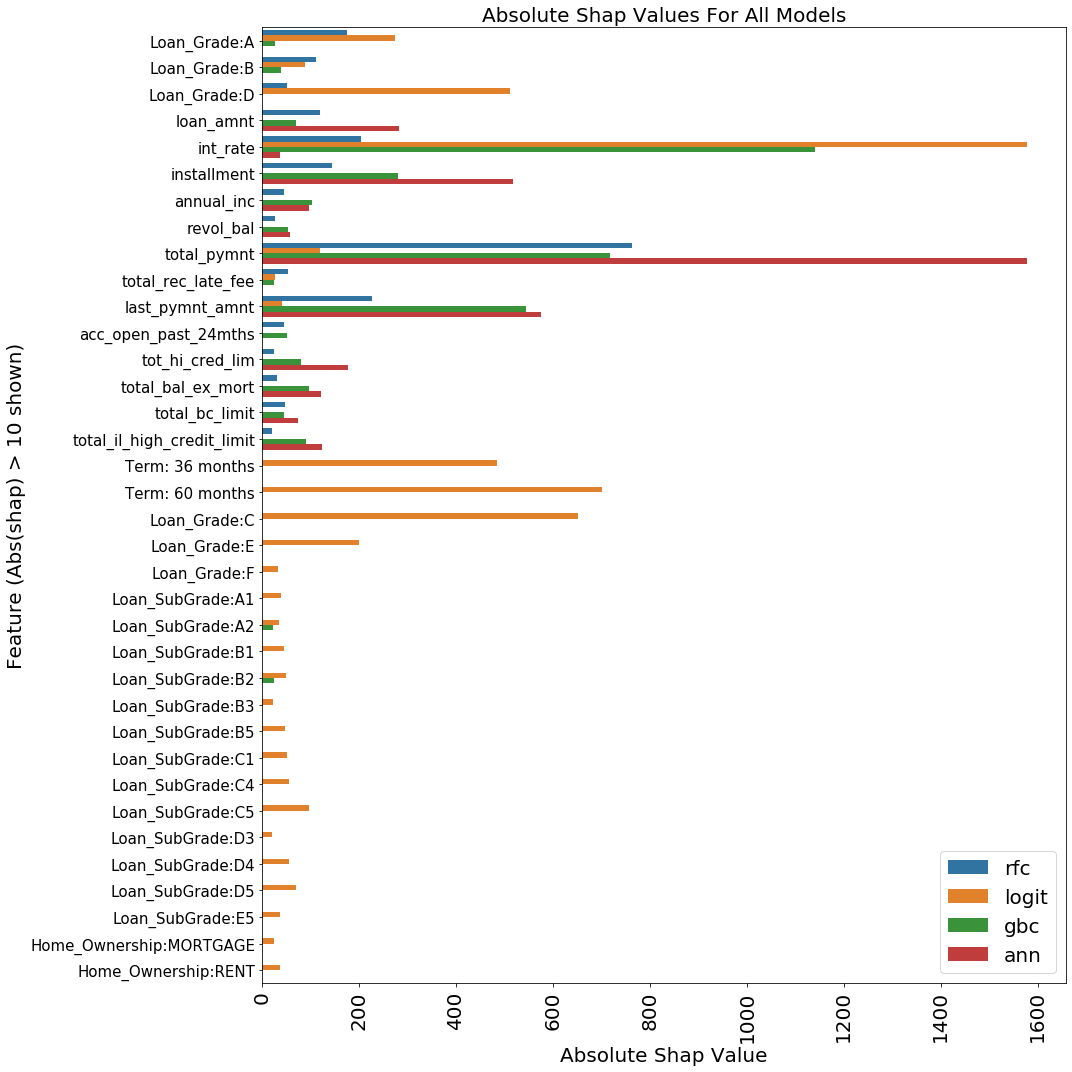

In [117]:
test1 = pd.read_csv('C:\\Users\\jdine\\Documents\\1.MachineLearning\hicss2020 - Copy\\obj\\lendingclub\\shap\\All_Abs_Sum_ShapValues_v2.csv')
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 15))

test1.columns
melted = test1.melt('Unnamed: 0')

melted = melted[melted['value'] > 20]
sns.barplot(melted['value'],melted['Unnamed: 0'], hue= melted['variable'])
plt.title('Absolute Shap Values For All Models', size = 20)
plt.xticks(rotation=90, size = 20)
plt.yticks(size = 15)
plt.legend(loc = 'lower right', prop={'size': 20})
plt.xlabel('Absolute Shap Value', size = 20)
plt.ylabel('Feature (Abs(shap) > 10 shown)', size = 20)
plt.show()

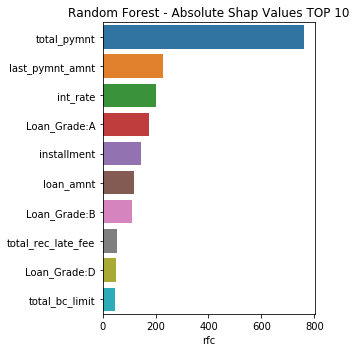

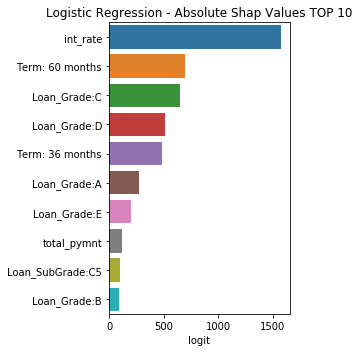

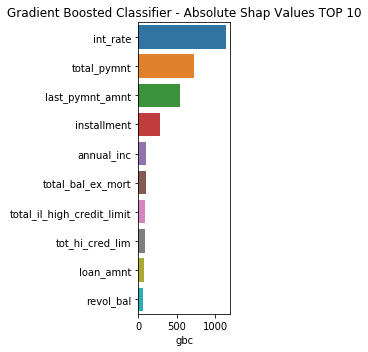

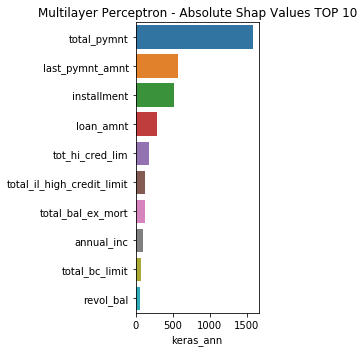

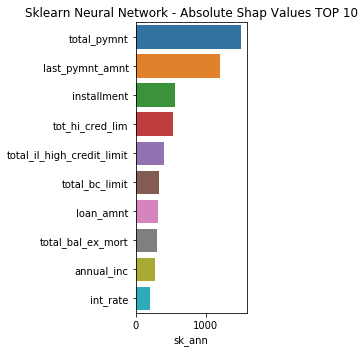

In [290]:
# ---------------------------------------------------------------------------------------------------------------
# Shap Summing and Absolute Summing of Shap Values
# ---------------------------------------------------------------------------------------------------------------
'''
Absolute and summation of shap values can be found @ obj/lendingclub/shap/ as csv files
The below will output the top ten ranked by absolute value, and the top and bottom 5 feats. by raw magnitude.
'''
rcParams['figure.figsize'] = 5,5  # Adjust plot size

display_abs_shapvalues(features=unrolled_features,
                       num_features=10)

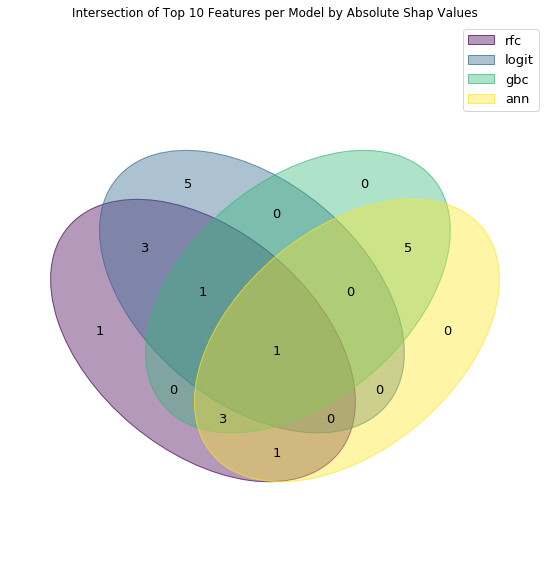

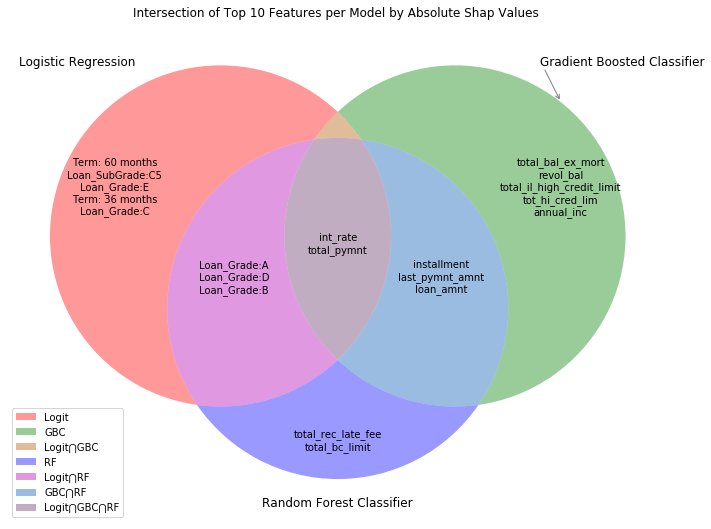

In [351]:
rcParams['figure.figsize'] = 10,10  # Adjust plot size

from venn import venn
combined_shap = pd.read_csv('obj/lendingclub/shap/All_Abs_Sum_ShapValues_v2.csv', index_col = 0)
models_str = ['Random Forest', 'Logistic Regression','Gradient Boosted Classifier', 'Multilayer Perceptron', 'Sklearn Neural Network']
shap_values_top = {}
for i,j in zip(combined_shap.columns, models_str):
    temp = combined_shap.nlargest(10, i)
    shap_values_top[i] = set(temp[i].index)
venn(shap_values_top)
plt.title('Intersection of Top 10 Features per Model by Absolute Shap Values ')
plt.savefig('venn_diagram_Fig4_Replacement_v2.png', eps = 1000, bbox_inches = "tight")

plt.show()

logit_top= set(shap_values_top['logit'])
gbc_top = set(shap_values_top['gbc'])
rfc_top = set(shap_values_top['rfc'])

#!pip install matplotlib-venn
from matplotlib_venn import venn3
v = venn3([logit_top, gbc_top, rfc_top], ('Logistic Regression', 'Gradient Boosted Classifier', 'Random Forest Classifier'))
v.get_label_by_id('100').set_text('\n'.join(logit_top-gbc_top-rfc_top)) #Just Logit
v.get_label_by_id('110').set_text('\n'.join(logit_top&gbc_top-rfc_top)) #Intersection of Logit and 
v.get_label_by_id('111').set_text('\n'.join(logit_top&gbc_top&rfc_top))
v.get_label_by_id('010').set_text('\n'.join(gbc_top-logit_top-rfc_top))
v.get_label_by_id('011').set_text('\n'.join(rfc_top&gbc_top-logit_top))
v.get_label_by_id('001').set_text('\n'.join(rfc_top-gbc_top-logit_top))
v.get_label_by_id('101').set_text('\n'.join(logit_top&rfc_top-gbc_top))

plt.annotate(',\n'.join(B-A-C), xy=v.get_label_by_id('010').get_position() +
             np.array([0, 0.2]), xytext=(-20,40), ha='center',
             textcoords='offset points', 
             bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->',              
                             connectionstyle='arc',color='gray'))
plt.title('Intersection of Top 10 Features per Model by Absolute Shap Values ')
plt.legend(['Logit','GBC', 'Logit⋂GBC', 'RF', 'Logit⋂RF', 'GBC⋂RF', 'Logit⋂GBC⋂RF'],loc = 'lower left')
plt.savefig('venn_diagram_Fig4_Replacement.png', eps = 1000, bbox_inches = "tight")
plt.show()

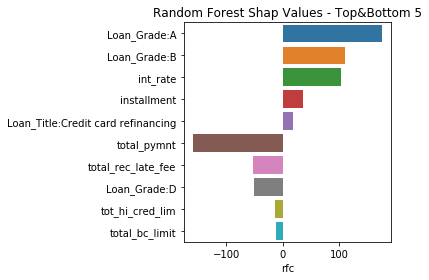

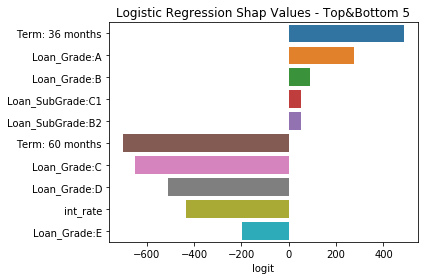

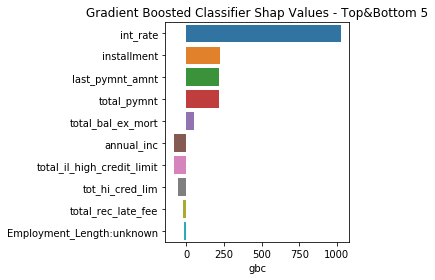

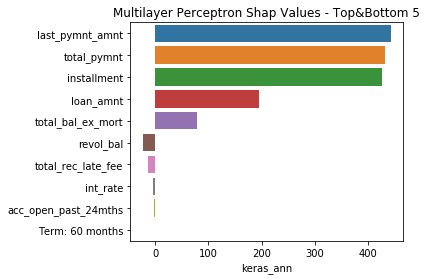

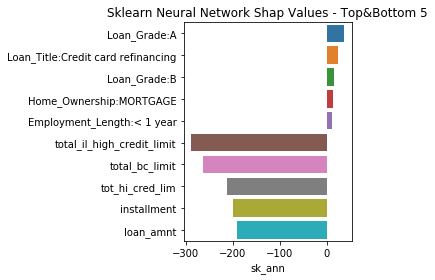

In [12]:
# ---------------------------------------------------------------------------------------------------------------
# Shap Top & Bottom 5 Summed
# ---------------------------------------------------------------------------------------------------------------
display_shapvalues(features=unrolled_features, n=10)


### Other Attributions Shapley/Saliency maps/Gradient * Input

In [13]:
# ---------------------------------------------------------------------------------------------------------------
# These were previously computed but not referenced in paper. Fetched locally using pickle
# ---------------------------------------------------------------------------------------------------------------

# Show integrated gradients of only continuous features
rcParams['figure.figsize'] = 5, 5
keras_ig_df = load_obj('data_objects/keras_ig_df')
attributions_gradin = load_obj('attributions_gradin')
attributions_sal = load_obj('attributions_sal')
attributions_elrp = load_obj('attributions_elrp')

attribution_dict = {'grad_x_input': attributions_gradin, 'saliency maps': attributions_sal,
                    'layerwise relevance propogation': attributions_elrp, 'integrated gradients': keras_ig_df}

# ---------------------------------------------------------------------------------------------------------------
# Plot Dotplots showing density of activations/grads etc..
# ---------------------------------------------------------------------------------------------------------------
@interact
def display_gam_feat_importance(attributions=[
        'grad_x_input', 'saliency maps', 'layerwise relevance propogation', 'integrated gradients'
], save=button_widg):

    # Load attributions and show columnwise dotplots. Note that we are only looking at the tail 14 features here.
    deep_df = pd.DataFrame(attribution_dict[attributions], columns=list(keras_ig_df.columns))
    deep_df = deep_df.iloc[:, -10:].melt(var_name='groups', value_name='vals')
    ax = sns.stripplot(x="vals", y="groups", data=deep_df, jitter=.5)
    if 'saliency maps' in attributions:
        plt.xlim(0, 0.30)
    else:
        plt.xlim(-75, 75)
    plt.title('{} Attributions'.format(attributions))
    if save:
        path = 'images/Non_shap_attributions/{}.png'.format(attributions)
        plt.savefig(path)
        print("Image saved to {}".format(path))


interactive(children=(Dropdown(description='attributions', options=('grad_x_input', 'saliency maps', 'layerwis…

### GAM

In [118]:
# ---------------------------------------------------------------------------------------------------------------
# GAM Helpers
# ---------------------------------------------------------------------------------------------------------------  
def shap_to_csv_all_models_test(model, num_obs, Positive_class , k):
    if Positive_class:
        inds = np.where(y_test == 1)[0][:num_obs]
    else:
        inds = np.where(y_test == 0)[0][:num_obs]
    
    file_name = models[str(type(model))][0]
    local = pd.DataFrame(models[str(type(model))][1], columns = unrolled_features).iloc[inds, :]
    local.to_csv('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs),
        index=False)
    gam_test = GAM(
        attributions_path='obj/lendingclub/gam/{}_{}obs_local.csv'.format(
            file_name, num_obs),
        k=k)
    gam_test.generate()
    os.remove('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs))
    return gam_test

def display_gam_test(gam, flag = 1):
    print('\t\t\t\tShowing GAM Explanation ')
    gam_nn_df = pd.DataFrame(gam.explanations[0],
                             columns=['features',
                                      'Feature Importance']).sort_values(
                                          by='Feature Importance',
                                          ascending=False)
    gam_nn_df = gam_nn_df[gam_nn_df['Feature Importance'] > 0]
    gam_nn_df['Feature Importance'] = np.round(
        gam_nn_df['Feature Importance'], 2)
    gam_nn_df.sort_values('Feature Importance', inplace = True)
    # print(gam_nn_df.to_string())
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(121)
    ax.barh(gam_nn_df['features'], gam_nn_df['Feature Importance'])
    ax.set_xlabel('Feature Importance', fontsize=10)
    ax.set_ylabel('Feature', fontsize='large')  
    if flag == 1:
        title = 'GOOD'
    else:
        title = "BAD"
    ax.set_title('GAM Multilayer Perceptron Explanation : Class {} Loans'.format(title))
    for i, v in enumerate(gam_nn_df['Feature Importance'].values):
        ax.text(v -.01, i , str(v), color='red', fontweight='bold')
    plt.tight_layout(rect=[0.11, 0.1, 1.6, .95])
    plt.savefig('images/Explanation_{}'.format(title), eps = 1000, bbox_inches = "tight")
    plt.show()
    print('-' * 100)

# ---------------------------------------------------------------------------------------------------------------
# Running GAM
# ---------------------------------------------------------------------------------------------------------------   
@interact
def display_gam_feat_importance_test(
        models=widgets.ToggleButtons(
            options=[
                keras_ann, logit,
                gbc, rfc
            ],
            description='Models:',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltips=[
                'keras sequential neural network', 'sklearn logit',
                'sklearn gradient boosted classifier', 'sklearn random forest'
            ]),
        num_obs=list(range(100, 2100, 100)),
        clusters=widgets.FloatText(value=1,
                                   description='# of clusters:',
                                   disabled=False), save=button_widg):
    gam = shap_to_csv_all_models_test(model=models,
                                 num_obs=num_obs, Positive_class = True,
                                 k=clusters)
    display_gam_test(gam, flag = 1)    
    gam = shap_to_csv_all_models_test(model=models,
                                 num_obs=num_obs, Positive_class = False,
                                 k=clusters)
    display_gam_test(gam, flag = 0) 
    


interactive(children=(ToggleButtons(description='Models:', options=(<keras.engine.sequential.Sequential object…